In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold 

In [2]:
df = pd.read_csv("./data/measurements.csv", decimal=',')

In [3]:
df['gas_type'] = pd.get_dummies(df['gas_type'])
df['specials'] = pd.get_dummies(df['specials'])
df['temp_inside'] = df['temp_inside'].fillna(df['temp_inside'].mean())
target = df['consume']
data = df.loc[:, ['distance', "speed", 'temp_inside' , 'temp_outside', 'gas_type', 'specials', 'AC', 'rain', 'sun']]

In [4]:
def cross_validation(data, target, clf, n_split):
    cross_valid_mse = 0
    cross_valid_rmse = 0
    cross_valid_mae = 0
    for train, test in KFold(n_splits=n_split, shuffle=True, random_state=111).split(data, target):
        data_train, target_train = data.iloc[train], target[train]
        data_test, target_test = data.iloc[test], target[test]
        clf.fit(data_train, target_train)

        predicted_target = clf.predict(data_test)
         # 平均二乗誤差 (MSE)
        cross_valid_mse += metrics.mean_squared_error(target_test, predicted_target)
        # 二乗平均平方根誤差 (RMSE)
        cross_valid_rmse += np.sqrt(metrics.mean_squared_error(target_test, predicted_target))
        # 平均絶対誤差 (MAE)
        cross_valid_mae += metrics.mean_absolute_error(target_test, predicted_target)
    mse = cross_valid_mse / n_split
    rmse = cross_valid_rmse / n_split
    mae = cross_valid_mae / n_split
    print({"MSE":mse, "RMSE":rmse, "MAE":mae})
    return {"MSE":mse, "RMSE":rmse, "MAE":mae}

In [5]:
clf = linear_model.LinearRegression(fit_intercept=True)

In [6]:
print("k=5", cross_validation(data, target, clf, 5))
print("k=10", cross_validation(data, target, clf, 10))
print("k=50", cross_validation(data, target, clf, 50))
print("k=100", cross_validation(data, target, clf, 100))
print("k=200", cross_validation(data, target, clf, 200))

{'MSE': 0.9063960130510713, 'RMSE': 0.9460838216793297, 'MAE': 0.640977822161328}
k=5 {'MSE': 0.9063960130510713, 'RMSE': 0.9460838216793297, 'MAE': 0.640977822161328}
{'MSE': 0.8988125522731384, 'RMSE': 0.9122947265099427, 'MAE': 0.6364269452677899}
k=10 {'MSE': 0.8988125522731384, 'RMSE': 0.9122947265099427, 'MAE': 0.6364269452677899}
{'MSE': 0.8835682729285999, 'RMSE': 0.8321495384147597, 'MAE': 0.6342443148228034}
k=50 {'MSE': 0.8835682729285999, 'RMSE': 0.8321495384147597, 'MAE': 0.6342443148228034}
{'MSE': 0.8848129284926175, 'RMSE': 0.7778682207704496, 'MAE': 0.6359339601213999}
k=100 {'MSE': 0.8848129284926175, 'RMSE': 0.7778682207704496, 'MAE': 0.6359339601213999}
{'MSE': 0.8866898410742773, 'RMSE': 0.7133418317725929, 'MAE': 0.6377328876003883}
k=200 {'MSE': 0.8866898410742773, 'RMSE': 0.7133418317725929, 'MAE': 0.6377328876003883}


In [7]:
# そのまま
as_it_is = cross_validation(data, target, clf, 50)

{'MSE': 0.8835682729285999, 'RMSE': 0.8321495384147597, 'MAE': 0.6342443148228034}


In [8]:
# 標準化
std_data = (data - data.mean()) / data.std()
std = cross_validation(std_data, target, clf, 50)

{'MSE': 0.8835682729286001, 'RMSE': 0.8321495384147597, 'MAE': 0.6342443148228033}


In [9]:
# 0~1に正規化
normalized_data = data.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
normalize = cross_validation(normalized_data, target, clf, 50)

{'MSE': 0.8835682729286001, 'RMSE': 0.8321495384147596, 'MAE': 0.6342443148228033}


In [10]:
# 正則化項のグリッドサーチ
def grid_search(data, target, n_split, lasso_or_ridge, range_searching_list):
    result_list = []
    for alpha in range_searching_list:
        if lasso_or_ridge == "lasso":
            clf = linear_model.Lasso(alpha=alpha, fit_intercept=True, copy_X=True, max_iter=1000, tol=0.0001,random_state=111)
        elif lasso_or_ridge == "ridge":
            clf = linear_model.Ridge(alpha=alpha, fit_intercept=True, copy_X=True, max_iter=1000, tol=0.0001,random_state=111)
        result = cross_validation(data, target, clf, n_split)
        result_list.append([alpha, result['MAE']])
        print(alpha, result)
    sorted_result_list = sorted(result_list, key=lambda x: x[1])
    print("MAE最小", sorted_result_list[0][0])
    clf = linear_model.Ridge(alpha=sorted_result_list[0][0], fit_intercept=True, copy_X=True, max_iter=1000, tol=0.0001,random_state=111)
    return cross_validation(data, target, clf, n_split)

In [11]:
# L1正則化
range_searching_list = np.arange(0.01, 1.01, 0.01)
lasso = grid_search(std_data, target, 50, "lasso",range_searching_list)

{'MSE': 0.8823471227845111, 'RMSE': 0.8290222059065835, 'MAE': 0.6305349473365056}
0.01 {'MSE': 0.8823471227845111, 'RMSE': 0.8290222059065835, 'MAE': 0.6305349473365056}
{'MSE': 0.8804653031133063, 'RMSE': 0.8252799211734465, 'MAE': 0.6257152153361318}
0.02 {'MSE': 0.8804653031133063, 'RMSE': 0.8252799211734465, 'MAE': 0.6257152153361318}
{'MSE': 0.8805523325506525, 'RMSE': 0.8225612366469174, 'MAE': 0.6222553260139785}
0.03 {'MSE': 0.8805523325506525, 'RMSE': 0.8225612366469174, 'MAE': 0.6222553260139785}
{'MSE': 0.8833956231296254, 'RMSE': 0.8213293414765261, 'MAE': 0.6202304347992047}
0.04 {'MSE': 0.8833956231296254, 'RMSE': 0.8213293414765261, 'MAE': 0.6202304347992047}
{'MSE': 0.8867943161090603, 'RMSE': 0.8205460283545146, 'MAE': 0.6190492147519087}
0.05 {'MSE': 0.8867943161090603, 'RMSE': 0.8205460283545146, 'MAE': 0.6190492147519087}
{'MSE': 0.8890415831376154, 'RMSE': 0.8196694417980119, 'MAE': 0.6181370780602166}
0.060000000000000005 {'MSE': 0.8890415831376154, 'RMSE': 0.819

{'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
0.48000000000000004 {'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
{'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
0.49 {'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
{'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
0.5 {'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
{'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
0.51 {'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
{'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
0.52 {'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
{'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
0.53 {'MSE': 1.0574439204093427, 'RMSE': 0.89334

{'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
0.97 {'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
{'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
0.98 {'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
{'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
0.99 {'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
{'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
1.0 {'MSE': 1.0574439204093427, 'RMSE': 0.8933466617328004, 'MAE': 0.6762481232609082}
MAE最小 0.08
{'MSE': 0.8835550933413984, 'RMSE': 0.8321329576244331, 'MAE': 0.6342253887491457}


In [12]:
# L2正則化
range_searching_list = np.arange(200, 300, 1)
ridge = grid_search(std_data, target, 50, "ridge", range_searching_list)

{'MSE': 0.8873424323066251, 'RMSE': 0.8204869309765331, 'MAE': 0.6181161555010051}
200 {'MSE': 0.8873424323066251, 'RMSE': 0.8204869309765331, 'MAE': 0.6181161555010051}
{'MSE': 0.8874245318996408, 'RMSE': 0.8204906772882508, 'MAE': 0.6181047707638069}
201 {'MSE': 0.8874245318996408, 'RMSE': 0.8204906772882508, 'MAE': 0.6181047707638069}
{'MSE': 0.8875067962718343, 'RMSE': 0.8204946740310375, 'MAE': 0.6180934261869755}
202 {'MSE': 0.8875067962718343, 'RMSE': 0.8204946740310375, 'MAE': 0.6180934261869755}
{'MSE': 0.8875892227843596, 'RMSE': 0.8204989188386008, 'MAE': 0.6180821215469682}
203 {'MSE': 0.8875892227843596, 'RMSE': 0.8204989188386008, 'MAE': 0.6180821215469682}
{'MSE': 0.8876718088307721, 'RMSE': 0.8205034093700547, 'MAE': 0.6180708566219889}
204 {'MSE': 0.8876718088307721, 'RMSE': 0.8205034093700547, 'MAE': 0.6180708566219889}
{'MSE': 0.887754551836555, 'RMSE': 0.8205081433095711, 'MAE': 0.6180596311919679}
205 {'MSE': 0.887754551836555, 'RMSE': 0.8205081433095711, 'MAE': 0.

{'MSE': 0.8915165414737436, 'RMSE': 0.8209262046122605, 'MAE': 0.6179485705699517}
249 {'MSE': 0.8915165414737436, 'RMSE': 0.8209262046122605, 'MAE': 0.6179485705699517}
{'MSE': 0.891604122567901, 'RMSE': 0.8209398435730296, 'MAE': 0.6179480356848712}
250 {'MSE': 0.891604122567901, 'RMSE': 0.8209398435730296, 'MAE': 0.6179480356848712}
{'MSE': 0.8916917700222491, 'RMSE': 0.8209536415516225, 'MAE': 0.6179475049059185}
251 {'MSE': 0.8916917700222491, 'RMSE': 0.8209536415516225, 'MAE': 0.6179475049059185}
{'MSE': 0.8917794823536986, 'RMSE': 0.8209675971061232, 'MAE': 0.6179469782053123}
252 {'MSE': 0.8917794823536986, 'RMSE': 0.8209675971061232, 'MAE': 0.6179469782053123}
{'MSE': 0.8918672580957515, 'RMSE': 0.82098170880822, 'MAE': 0.6179464555554841}
253 {'MSE': 0.8918672580957515, 'RMSE': 0.82098170880822, 'MAE': 0.6179464555554841}
{'MSE': 0.8919550957982918, 'RMSE': 0.8209959752430506, 'MAE': 0.6179459369290737}
254 {'MSE': 0.8919550957982918, 'RMSE': 0.8209959752430506, 'MAE': 0.6179

{'MSE': 0.8958618872309377, 'RMSE': 0.8217575609749033, 'MAE': 0.6181808215444304}
298 {'MSE': 0.8958618872309377, 'RMSE': 0.8217575609749033, 'MAE': 0.6181808215444304}
{'MSE': 0.8959512426319354, 'RMSE': 0.8217775169455348, 'MAE': 0.6181875471210789}
299 {'MSE': 0.8959512426319354, 'RMSE': 0.8217775169455348, 'MAE': 0.6181875471210789}
MAE最小 256
{'MSE': 0.8921309513650566, 'RMSE': 0.8210249667177523, 'MAE': 0.6179454037411671}


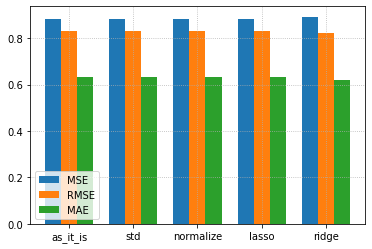

In [37]:
mse_list = [as_it_is['MSE'], std['MSE'], normalize['MSE'], lasso['MSE'], ridge['MSE']]
rmse_list = [as_it_is['RMSE'], std['RMSE'], normalize['RMSE'], lasso['RMSE'], ridge['RMSE']]
mae_list = [as_it_is['MAE'], std['MAE'], normalize['MAE'], lasso['MAE'], ridge['MAE']]

 
left = np.arange(len(mse_list))  # numpyで横軸を設定
labels = ['as_it_is', 'std', 'normalize', 'lasso', 'ridge']

width = 0.25
 
plt.bar(left, mse_list, width=width, align='center', label="MSE")
plt.bar(left+width, rmse_list, width=width, align='center', label="RMSE")
plt.bar(left+width+width, mae_list, width=width, align='center', label="MAE")

plt.legend(loc='lower left')
plt.xticks(left + width, labels)
plt.grid(linestyle='dotted')
plt.show()

In [14]:
result = pd.DataFrame([mse_list, rmse_list, mae_list], index=["MSE", "RMSE", "MAE"]).T
result.index = ["そのまま","標準化","正規化", "L1正則化", "L2正則化"]
pd.options.display.precision = 16
display(result)

,MSE,RMSE,MAE
そのまま,0.8835682729285999,0.8321495384147597,0.6342443148228034
標準化,0.8835682729286001,0.8321495384147597,0.6342443148228033
正規化,0.8835682729286001,0.8321495384147596,0.6342443148228033
L1正則化,0.8835550933413984,0.8321329576244331,0.6342253887491457
L2正則化,0.8921309513650566,0.8210249667177523,0.6179454037411671


In [56]:
pd.concat([result.idxmin(), result.min()], axis=1)

,0,1
MSE,L1正則化,0.8835550933413984
RMSE,L2正則化,0.8210249667177523
MAE,L2正則化,0.6179454037411671
